# Introduction

<center><img src="https://i.imgur.com/9hLRsjZ.jpg" height=400></center>

This dataset was scraped from [nextspaceflight.com](https://nextspaceflight.com/launches/past/?page=1) and includes all the space missions since the beginning of Space Race between the USA and the Soviet Union in 1957!

### Install Package with Country Codes

In [117]:
%pip install iso3166

### Upgrade Plotly

Run the cell below if you are working with Google Colab.

In [118]:
%pip install --upgrade plotly

### Import Statements

In [119]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from iso3166 import countries
from datetime import datetime, timedelta

### Notebook Presentation

In [120]:
pd.options.display.float_format = '{:,.2f}'.format

### Load the Data

In [121]:
df_data = pd.read_csv('mission_launches.csv')


# Preliminary Data Exploration

* What is the shape of `df_data`?
* How many rows and columns does it have?
* What are the column names?
* Are there any NaN values or duplicates?

In [122]:
print(df_data.shape)
print(df_data.columns)


(4324, 9)
Index(['Unnamed: 0.1', 'Unnamed: 0', 'Organisation', 'Location', 'Date',
       'Detail', 'Rocket_Status', 'Price', 'Mission_Status'],
      dtype='object')


In [123]:
print(df_data.isnull().sum())
print(df_data.duplicated().sum())

Unnamed: 0.1         0
Unnamed: 0           0
Organisation         0
Location             0
Date                 0
Detail               0
Rocket_Status        0
Price             3360
Mission_Status       0
dtype: int64
0


## Data Cleaning - Check for Missing Values and Duplicates

Consider removing columns containing junk data.

In [124]:
print(df_data.isnull().sum())

Unnamed: 0.1         0
Unnamed: 0           0
Organisation         0
Location             0
Date                 0
Detail               0
Rocket_Status        0
Price             3360
Mission_Status       0
dtype: int64


In [125]:
df_data = df_data.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)


## Descriptive Statistics

In [126]:
df_data.describe(include='all')

,Organisation,Location,Date,Detail,Rocket_Status,Price,Mission_Status
count,4324,4324,4324,4324,4324,964,4324
unique,56,137,4319,4278,2,56,4
top,RVSN USSR,"Site 31/6, Baikonur Cosmodrome, Kazakhstan","Tue Aug 28, 1990 09:05 UTC",Cosmos-3MRB (65MRB) | BOR-5 Shuttle,StatusRetired,450.0,Success
freq,1777,235,2,6,3534,136,3879


# Number of Launches per Company

Create a chart that shows the number of space mission launches by organisation.

In [127]:

data_by_organisation = df_data.groupby('Organisation')['Organisation'].count().sort_values(ascending=False)
data_by_organisation = data_by_organisation.to_frame()

In [128]:

data_by_organisation.columns = ['count']
data_by_organisation.index.name = 'Organisation'



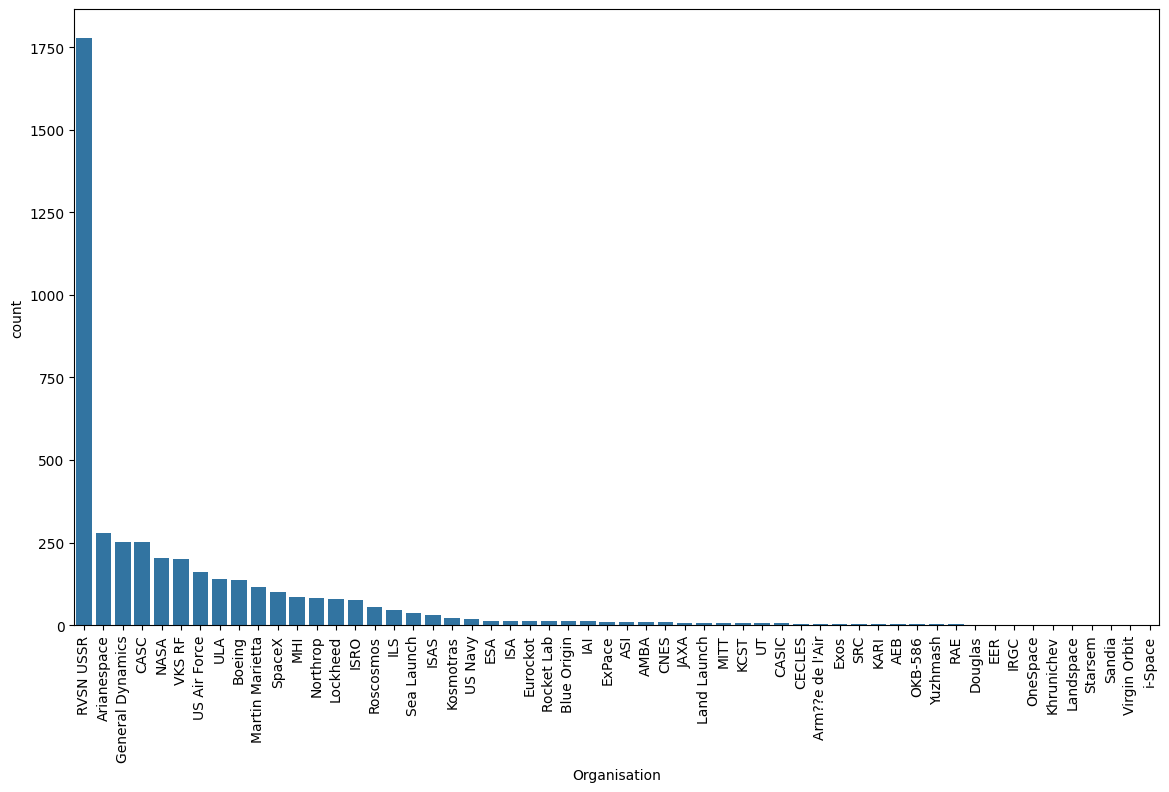

In [129]:
plt.figure(figsize=(14,8))
sns.barplot(x=data_by_organisation.index, y='count', data=data_by_organisation)
plt.xticks(rotation=90)
plt.show()

# Number of Active versus Retired Rockets

How many rockets are active compared to those that are decomissioned?

In [130]:
rocket_status_counts = df_data['Rocket_Status'].value_counts()

print("Number of Active Rockets:", rocket_status_counts['StatusActive'])
print("Number of Decommissioned Rockets:", rocket_status_counts['StatusRetired'])

Number of Active Rockets: 790
Number of Decommissioned Rockets: 3534


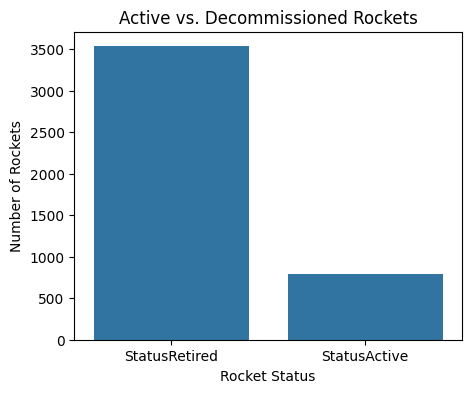

In [131]:
plt.figure(figsize=(5,4))
sns.barplot(x=rocket_status_counts.index, y=rocket_status_counts.values)
plt.xlabel('Rocket Status')
plt.ylabel('Number of Rockets')
plt.title('Active vs. Decommissioned Rockets')
plt.show()

# Distribution of Mission Status

How many missions were successful?
How many missions failed?

Number of successful missions: 3879
Number of failed missions: 339


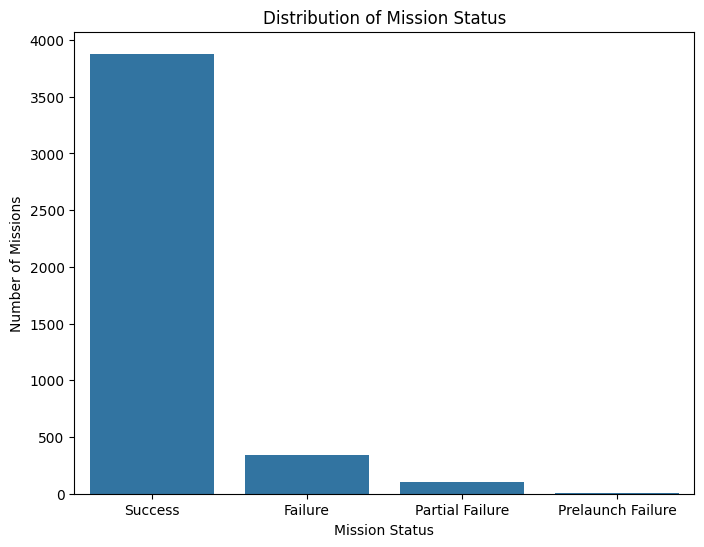

In [132]:
mission_status_counts = df_data['Mission_Status'].value_counts()

print("Number of successful missions:", mission_status_counts['Success'])
print("Number of failed missions:", mission_status_counts['Failure'])

plt.figure(figsize=(8,6))
sns.barplot(x=mission_status_counts.index, y=mission_status_counts.values)
plt.xlabel('Mission Status')
plt.ylabel('Number of Missions')
plt.title('Distribution of Mission Status')
plt.show()

# How Expensive are the Launches?

Create a histogram and visualise the distribution. The price column is given in USD millions (careful of missing values).

In [133]:
df_data['Price'] = df_data['Price'].str.replace(',', '')
df_data['Price'] = pd.to_numeric(df_data['Price'], errors='coerce')
df_price = df_data.dropna(subset=['Price']).copy()

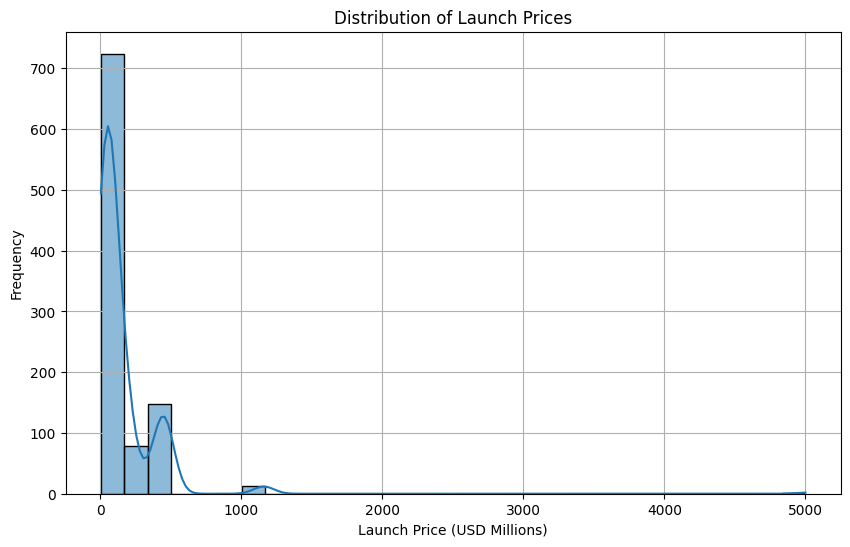

In [134]:
plt.figure(figsize=(10, 6))
sns.histplot(df_price['Price'], bins=30, kde=True)
plt.xlabel('Launch Price (USD Millions)')
plt.ylabel('Frequency')
plt.title('Distribution of Launch Prices')
plt.grid(True)
plt.show()

# Use a Choropleth Map to Show the Number of Launches by Country

* Create a choropleth map using [the plotly documentation](https://plotly.com/python/choropleth-maps/)
* Experiment with [plotly's available colours](https://plotly.com/python/builtin-colorscales/). I quite like the sequential colour `matter` on this map.
* You'll need to extract a `country` feature as well as change the country names that no longer exist.

Wrangle the Country Names

You'll need to use a 3 letter country code for each country. You might have to change some country names.

* Russia is the Russian Federation
* New Mexico should be USA
* Yellow Sea refers to China
* Shahrud Missile Test Site should be Iran
* Pacific Missile Range Facility should be USA
* Barents Sea should be Russian Federation
* Gran Canaria should be USA


You can use the iso3166 package to convert the country names to Alpha3 format.

In [135]:
def get_country_code(location):
    location = location.split(', ')[-1]
    location = location.replace('Russia', 'Russian Federation')
    location = location.replace('New Mexico', 'USA')
    location = location.replace('Yellow Sea', 'China')
    location = location.replace('Shahrud Missile Test Site', 'Iran')
    location = location.replace('Pacific Missile Range Facility', 'USA')
    location = location.replace('Barents Sea', 'Russian Federation')
    location = location.replace('Gran Canaria', 'USA')

    try:
        return countries.get(location).alpha3
    except KeyError:
        return None



In [136]:
df_data['country'] = df_data['Location'].apply(get_country_code)

launches_by_country = df_data.groupby('country').size().reset_index(name='number_of_launches')
launches_by_country = launches_by_country.dropna(subset=['country'])


fig = px.choropleth(launches_by_country,
                    locations='country',
                    color='number_of_launches',
                    hover_name='country',
                    color_continuous_scale="matter",
                    title='Number of Launches by Country')
fig.show()

# Use a Choropleth Map to Show the Number of Failures by Country


In [137]:
failures_by_country = df_data[df_data['Mission_Status'] == 'Failure'].groupby('country').size().reset_index(name='number_of_failures')
failures_by_country = failures_by_country.dropna(subset=['country'])

fig = px.choropleth(failures_by_country,
                    locations='country',
                    color='number_of_failures',
                    hover_name='country',
                    color_continuous_scale="matter",
                    title='Number of Failures by Country')
fig.show()

# Create a Plotly Sunburst Chart of the countries, organisations, and mission status.

In [138]:

df_data['country'] = df_data['Location'].apply(get_country_code)

df_data_cleaned = df_data.dropna(subset=['country']).copy()



In [139]:
fig = px.sunburst(df_data_cleaned,
                  path=['country', 'Organisation', 'Mission_Status'],
                  title='Launches by Country, Organisation, and Mission Status')
fig.show()

# Analyse the Total Amount of Money Spent by Organisation on Space Missions

In [140]:
organisation_spending = df_data.groupby('Organisation')['Price'].sum().sort_values(ascending=False).reset_index()



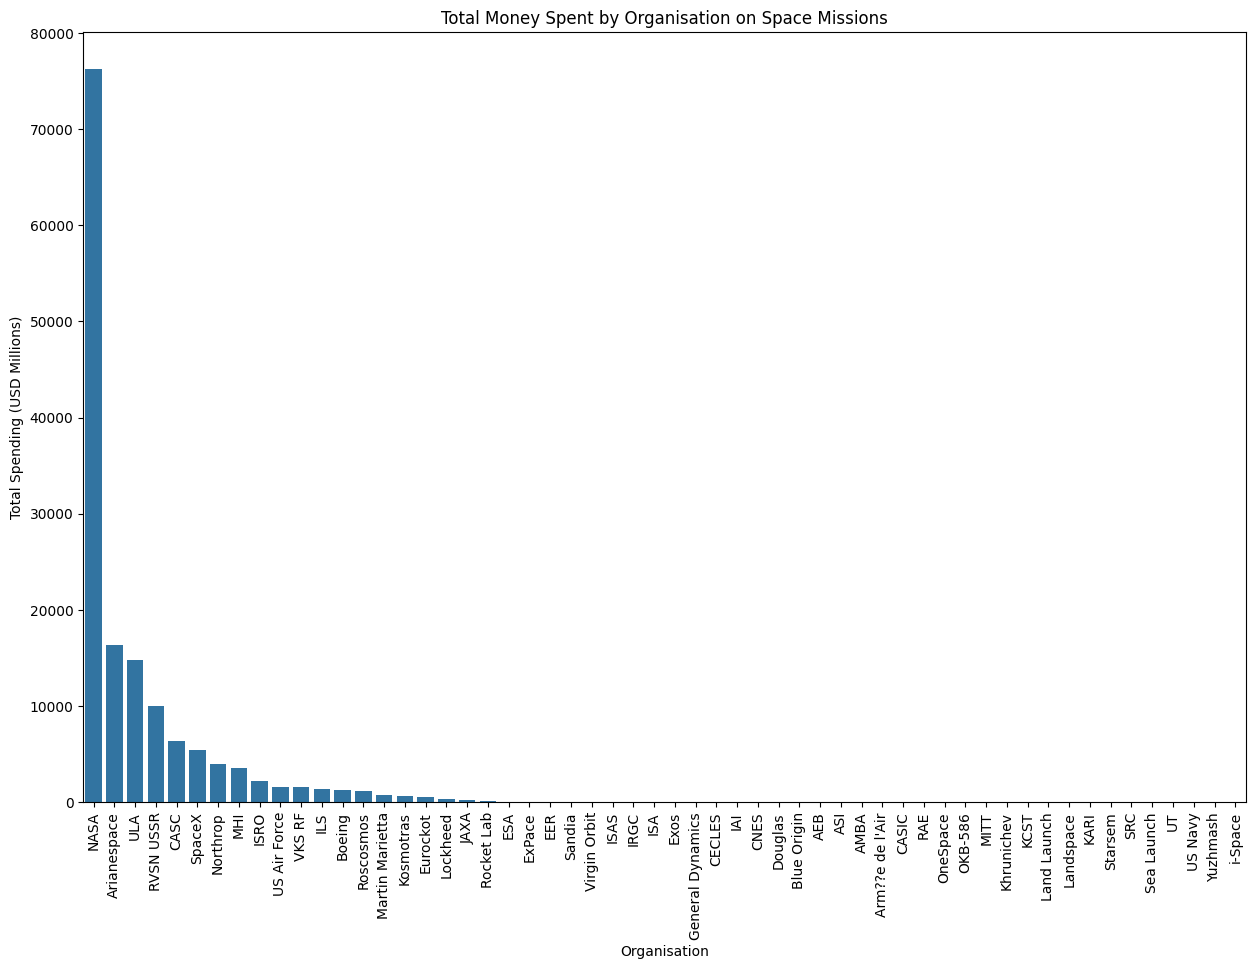

In [141]:
plt.figure(figsize=(15,10))
sns.barplot(x='Organisation', y='Price', data=organisation_spending)
plt.xticks(rotation=90)
plt.ylabel('Total Spending (USD Millions)')
plt.title('Total Money Spent by Organisation on Space Missions')
plt.show()

# Analyse the Amount of Money Spent by Organisation per Launch

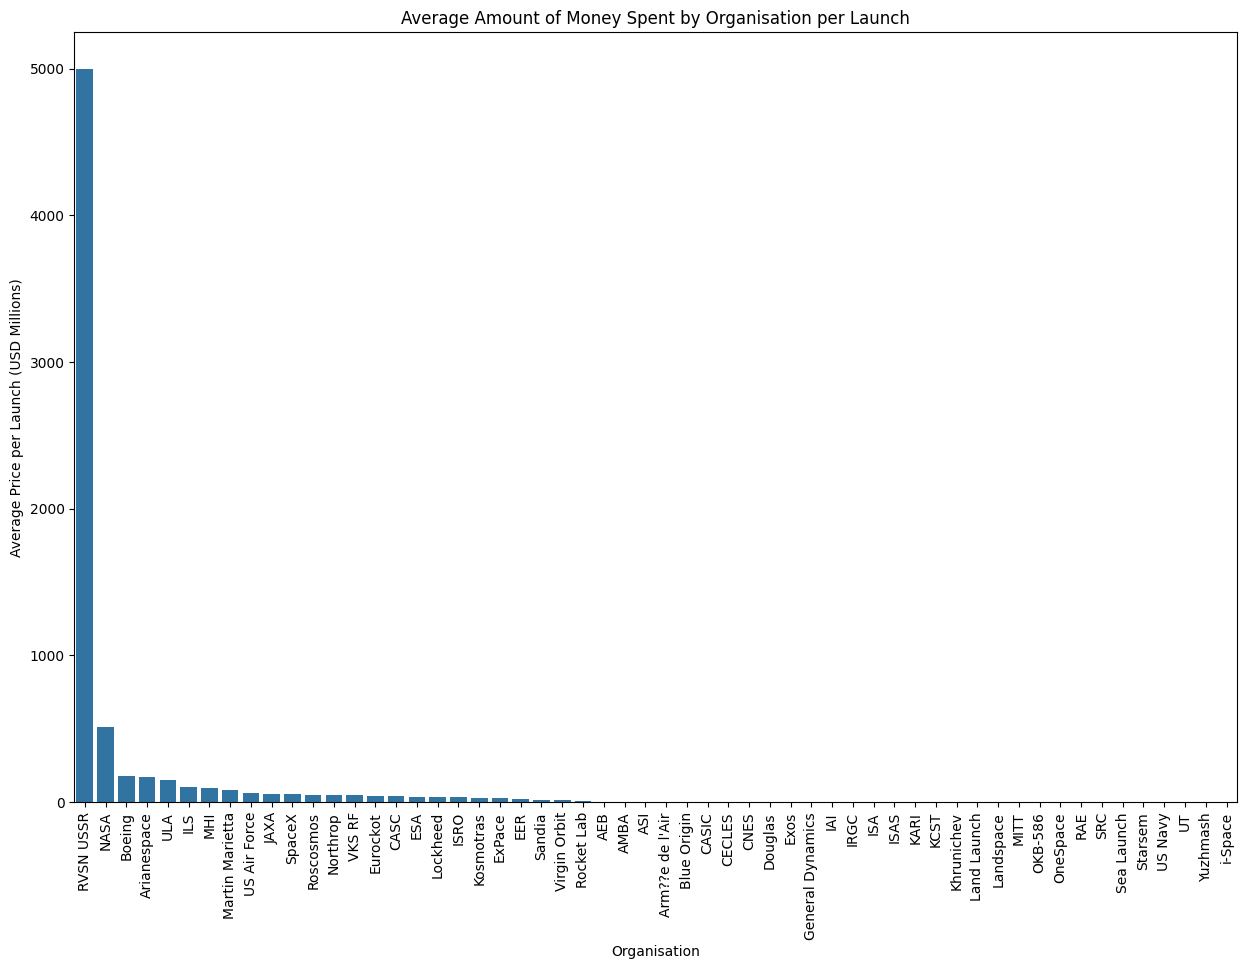

In [142]:
# prompt: Analyse the Amount of Money Spent by Organisation per Launch

organisation_avg_price_per_launch = df_data.groupby('Organisation')['Price'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(15,10))
sns.barplot(x='Organisation', y='Price', data=organisation_avg_price_per_launch)
plt.xticks(rotation=90)
plt.ylabel('Average Price per Launch (USD Millions)')
plt.title('Average Amount of Money Spent by Organisation per Launch')
plt.show()

# Chart the Number of Launches per Year

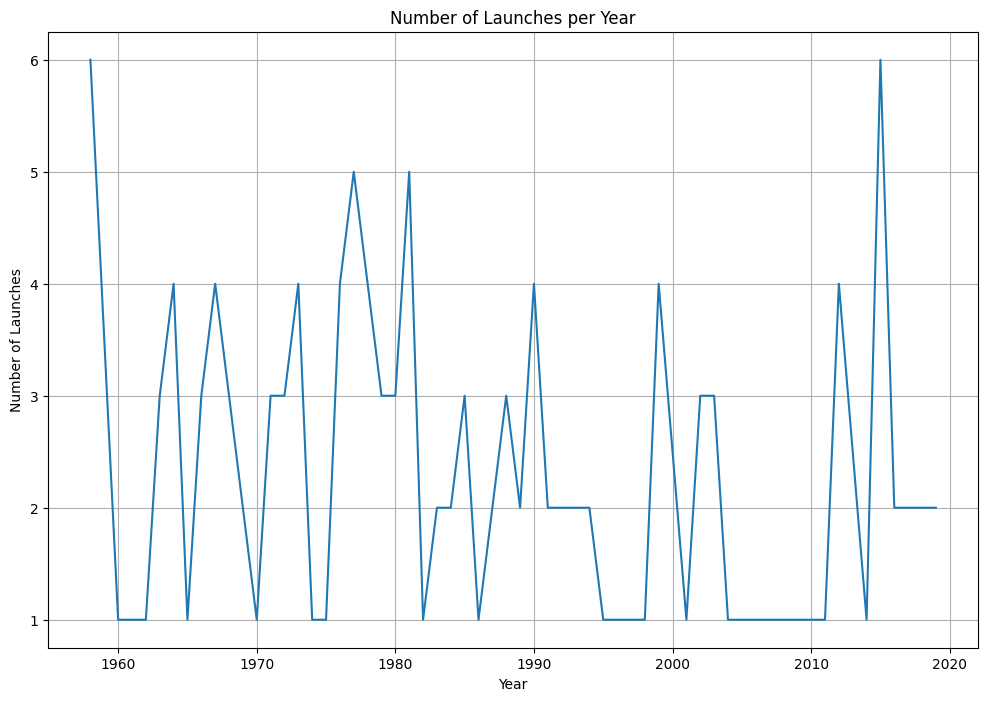

In [143]:
df_data['Date'] = pd.to_datetime(df_data['Date'], format='%a %b %d, %Y', utc=True, errors='coerce')
df_data['Year'] = df_data['Date'].dt.year

launches_per_year = df_data.groupby('Year').size().reset_index(name='number_of_launches')

plt.figure(figsize=(12, 8))
sns.lineplot(x='Year', y='number_of_launches', data=launches_per_year)
plt.xlabel('Year')
plt.ylabel('Number of Launches')
plt.title('Number of Launches per Year')
plt.grid(True)
plt.show()

# Chart the Number of Launches Month-on-Month until the Present

Which month has seen the highest number of launches in all time? Superimpose a rolling average on the month on month time series chart.

<ipython-input-144-1be1a1dac38c>:1: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



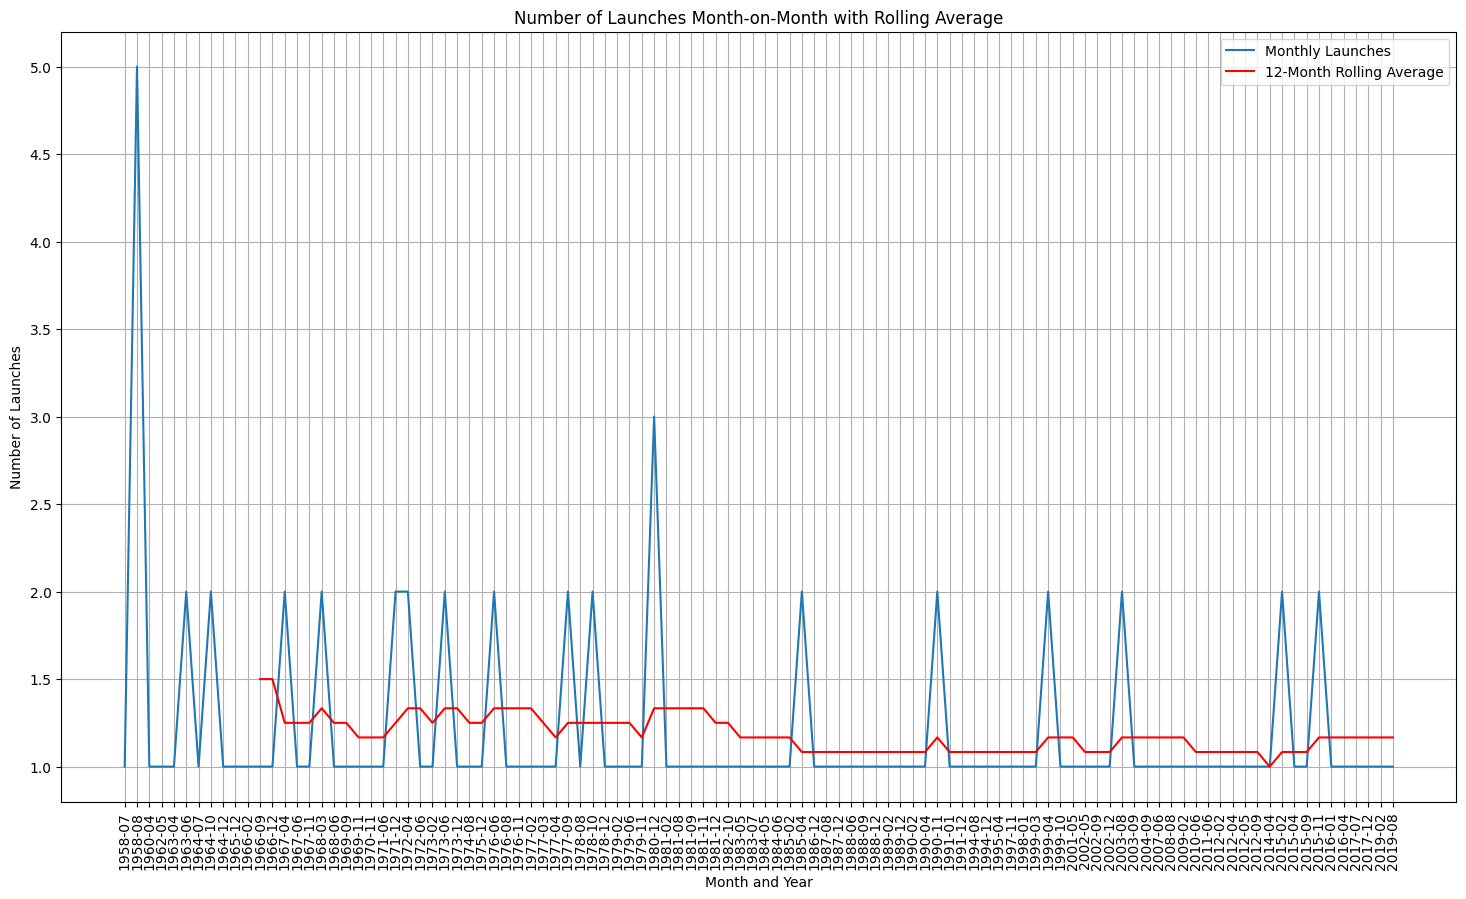


Month with the highest number of launches in all time:
Month
12    20
Name: number_of_launches, dtype: int64


In [144]:

df_data['Month_Year'] = df_data['Date'].dt.to_period('M')
launches_per_month = df_data.groupby('Month_Year').size().reset_index(name='number_of_launches')
launches_per_month['Month_Year'] = launches_per_month['Month_Year'].astype(str)


launches_per_month['Rolling_Average'] = launches_per_month['number_of_launches'].rolling(window=12).mean()

plt.figure(figsize=(18, 10))
sns.lineplot(x='Month_Year', y='number_of_launches', data=launches_per_month, label='Monthly Launches')
sns.lineplot(x='Month_Year', y='Rolling_Average', data=launches_per_month, color='red', label='12-Month Rolling Average')

plt.xlabel('Month and Year')
plt.ylabel('Number of Launches')
plt.title('Number of Launches Month-on-Month with Rolling Average')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()
plt.show()

launches_per_month['Month'] = pd.to_datetime(launches_per_month['Month_Year']).dt.month
highest_month_launches = launches_per_month.groupby('Month')['number_of_launches'].sum().sort_values(ascending=False)

print("\nMonth with the highest number of launches in all time:")
print(highest_month_launches.head(1))

# Launches per Month: Which months are most popular and least popular for launches?

Some months have better weather than others. Which time of year seems to be best for space missions?

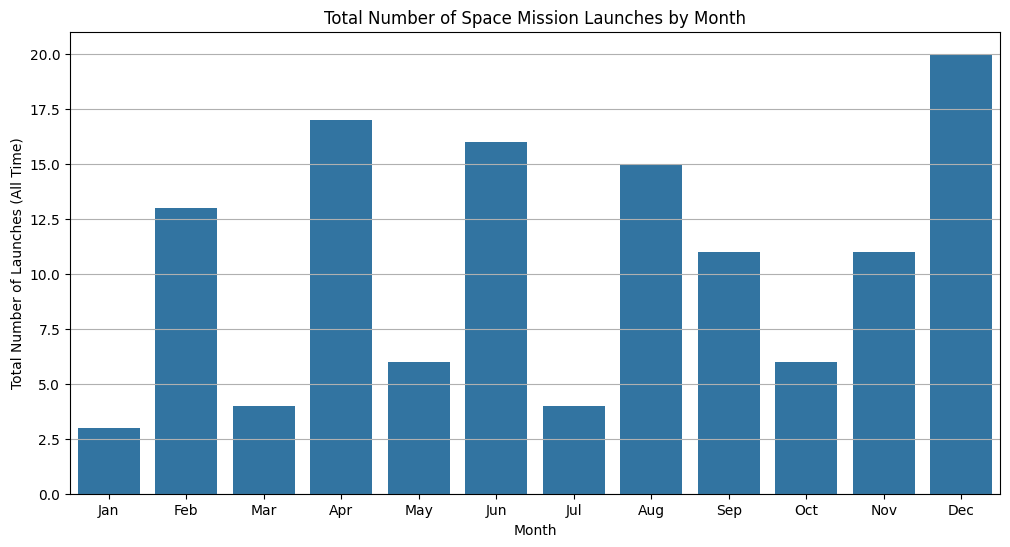


Most popular month for launches (all time): Dec (20 launches)
Least popular month for launches (all time): Jan (3 launches)


In [145]:
df_data['Month'] = df_data['Date'].dt.month
launches_per_calendar_month = df_data.groupby('Month').size().reset_index(name='number_of_launches')

month_names = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
launches_per_calendar_month['Month_Name'] = launches_per_calendar_month['Month'].map(month_names)

launches_per_calendar_month = launches_per_calendar_month.sort_values(by='Month')

plt.figure(figsize=(12, 6))
sns.barplot(x='Month_Name', y='number_of_launches', data=launches_per_calendar_month)
plt.xlabel('Month')
plt.ylabel('Total Number of Launches (All Time)')
plt.title('Total Number of Space Mission Launches by Month')
plt.grid(axis='y')
plt.show()

most_popular_month = launches_per_calendar_month.loc[launches_per_calendar_month['number_of_launches'].idxmax()]
least_popular_month = launches_per_calendar_month.loc[launches_per_calendar_month['number_of_launches'].idxmin()]

print(f"\nMost popular month for launches (all time): {most_popular_month['Month_Name']} ({most_popular_month['number_of_launches']} launches)")
print(f"Least popular month for launches (all time): {least_popular_month['Month_Name']} ({least_popular_month['number_of_launches']} launches)")

# How has the Launch Price varied Over Time?

Create a line chart that shows the average price of rocket launches over time.

In [146]:
df_data['Date'] = pd.to_datetime(df_data['Date'], format='%a %b %d, %Y', utc=True, errors='coerce')
df_data['Year'] = df_data['Date'].dt.year

average_price_per_year = df_data.groupby('Year')['Price'].mean().reset_index()

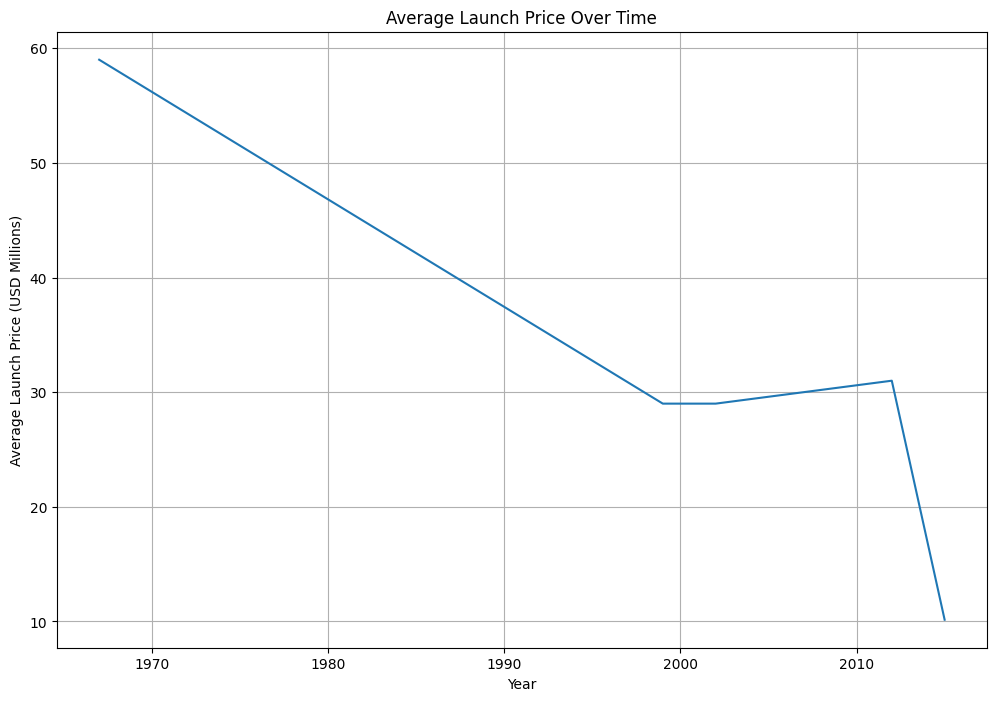

In [147]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='Year', y='Price', data=average_price_per_year)
plt.xlabel('Year')
plt.ylabel('Average Launch Price (USD Millions)')
plt.title('Average Launch Price Over Time')
plt.grid(True)
plt.show()

# Chart the Number of Launches over Time by the Top 10 Organisations.

How has the dominance of launches changed over time between the different players?

In [148]:
top_10_organisations = df_data.groupby('Organisation').size().nlargest(10).index

df_top_10 = df_data[df_data['Organisation'].isin(top_10_organisations)].copy()

launches_over_time_top_10 = df_top_10.groupby(['Year', 'Organisation']).size().reset_index(name='number_of_launches')

fig = px.line(launches_over_time_top_10,
              x='Year',
              y='number_of_launches',
              color='Organisation',
              title='Number of Launches Over Time by Top 10 Organisations')

fig.update_layout(xaxis_title='Year',
                  yaxis_title='Number of Launches')

fig.show()

# Cold War Space Race: USA vs USSR

The cold war lasted from the start of the dataset up until 1991.

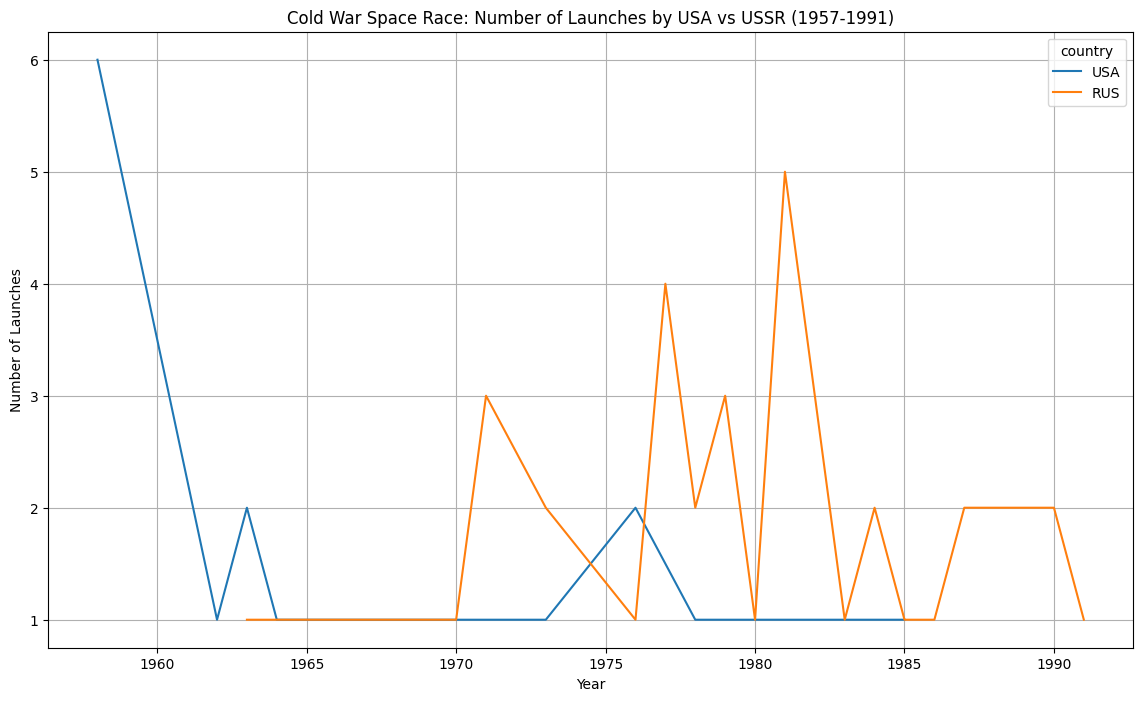

In [149]:

df_cold_war = df_data[df_data['Year'] <= 1991].copy()
df_cold_war['country'] = df_cold_war['Location'].apply(get_country_code)
df_cold_war_race = df_cold_war[df_cold_war['country'].isin(['USA', 'RUS'])].copy()

cold_war_launches_by_year_country = df_cold_war_race.groupby(['Year', 'country']).size().reset_index(name='number_of_launches')

plt.figure(figsize=(14, 8))
sns.lineplot(data=cold_war_launches_by_year_country, x='Year', y='number_of_launches', hue='country')
plt.xlabel('Year')
plt.ylabel('Number of Launches')
plt.title('Cold War Space Race: Number of Launches by USA vs USSR (1957-1991)')
plt.grid(True)
plt.show()



Cold War Space Race Mission Summary (USA vs USSR):
  country  total_launches  successful_launches  failure_launches  success_rate
0     RUS              42                   35                 7         83.33
1     USA              18                    6                12         33.33


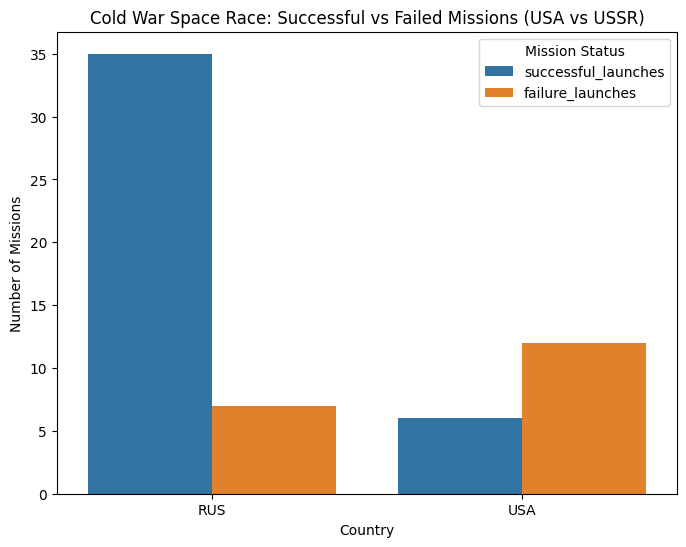

In [150]:
cold_war_success = df_cold_war_race[df_cold_war_race['Mission_Status'] == 'Success'].groupby('country').size().reset_index(name='successful_launches')
cold_war_total = df_cold_war_race.groupby('country').size().reset_index(name='total_launches')

cold_war_mission_summary = pd.merge(cold_war_total, cold_war_success, on='country', how='left').fillna(0)
cold_war_mission_summary['failure_launches'] = cold_war_mission_summary['total_launches'] - cold_war_mission_summary['successful_launches']
cold_war_mission_summary['success_rate'] = (cold_war_mission_summary['successful_launches'] / cold_war_mission_summary['total_launches']) * 100

print("\nCold War Space Race Mission Summary (USA vs USSR):")
print(cold_war_mission_summary)

cold_war_mission_summary_melted = cold_war_mission_summary.melt(id_vars='country', value_vars=['successful_launches', 'failure_launches'], var_name='Mission Status', value_name='Number of Launches')

plt.figure(figsize=(8, 6))
sns.barplot(data=cold_war_mission_summary_melted, x='country', y='Number of Launches', hue='Mission Status')
plt.xlabel('Country')
plt.ylabel('Number of Missions')
plt.title('Cold War Space Race: Successful vs Failed Missions (USA vs USSR)')
plt.show()

## Create a Plotly Pie Chart comparing the total number of launches of the USSR and the USA

Hint: Remember to include former Soviet Republics like Kazakhstan when analysing the total number of launches.

In [151]:
ussr_countries = [
    'RUS', # Russia (main successor state)
    'UKR', # Ukraine
    'BLR', # Belarus
    'KAZ', # Kazakhstan
    'UZB', # Uzbekistan
    'KGZ', # Kyrgyzstan
    'TJK', # Tajikistan
    'TKM', # Turkmenistan
    'MDA', # Moldova
    'ARM', # Armenia
    'AZE', # Azerbaijan
    'GEO', # Georgia
    'EST', # Estonia
    'LVA', # Latvia
    'LTU'  # Lithuania
]



In [152]:
countries_for_pie = ['USA'] + ussr_countries

df_pie = df_data[df_data['country'].isin(countries_for_pie)].copy()
df_pie['group'] = df_pie['country'].apply(lambda x: 'USA' if x == 'USA' else 'USSR/Former USSR')

launches_by_group = df_pie.groupby('group').size().reset_index(name='number_of_launches')

fig = px.pie(launches_by_group,
             values='number_of_launches',
             names='group',
             title='Total Number of Launches: USA vs USSR/Former USSR')
fig.show()

## Create a Chart that Shows the Total Number of Launches Year-On-Year by the Two Superpowers

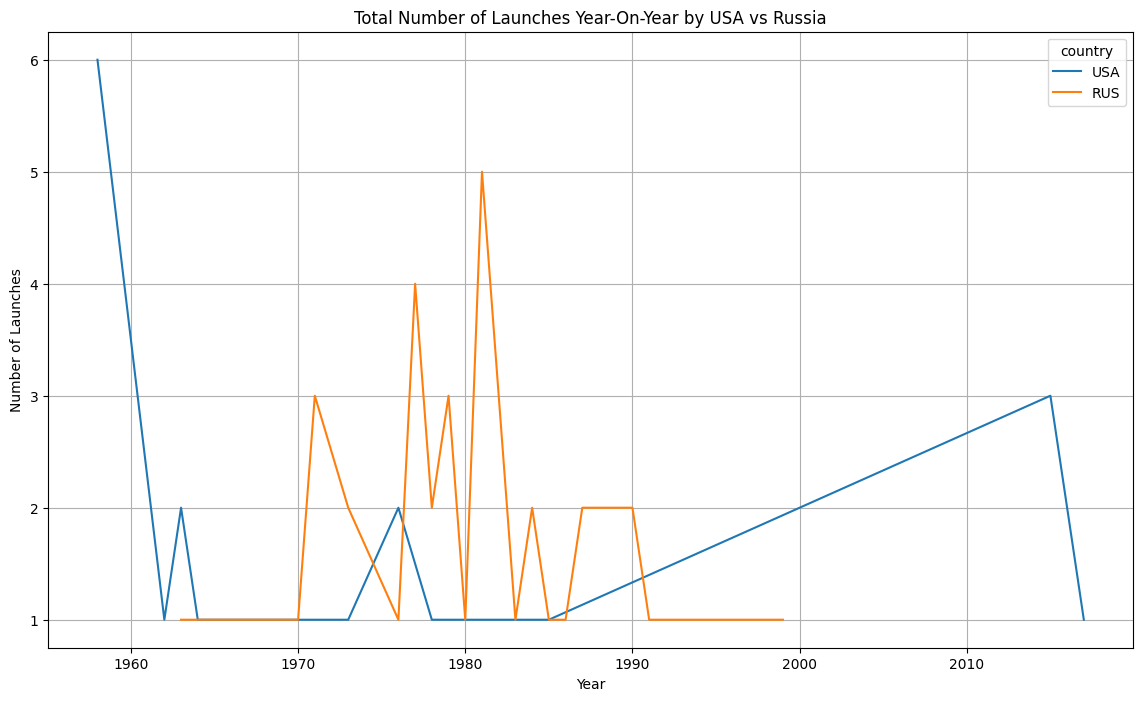

In [153]:
df_superpowers = df_data[df_data['country'].isin(['USA', 'RUS'])].copy()

superpower_launches_by_year = df_superpowers.groupby(['Year', 'country']).size().reset_index(name='number_of_launches')

plt.figure(figsize=(14, 8))
sns.lineplot(data=superpower_launches_by_year, x='Year', y='number_of_launches', hue='country')
plt.xlabel('Year')
plt.ylabel('Number of Launches')
plt.title('Total Number of Launches Year-On-Year by USA vs Russia')
plt.grid(True)
plt.show()

## Chart the Total Number of Mission Failures Year on Year.

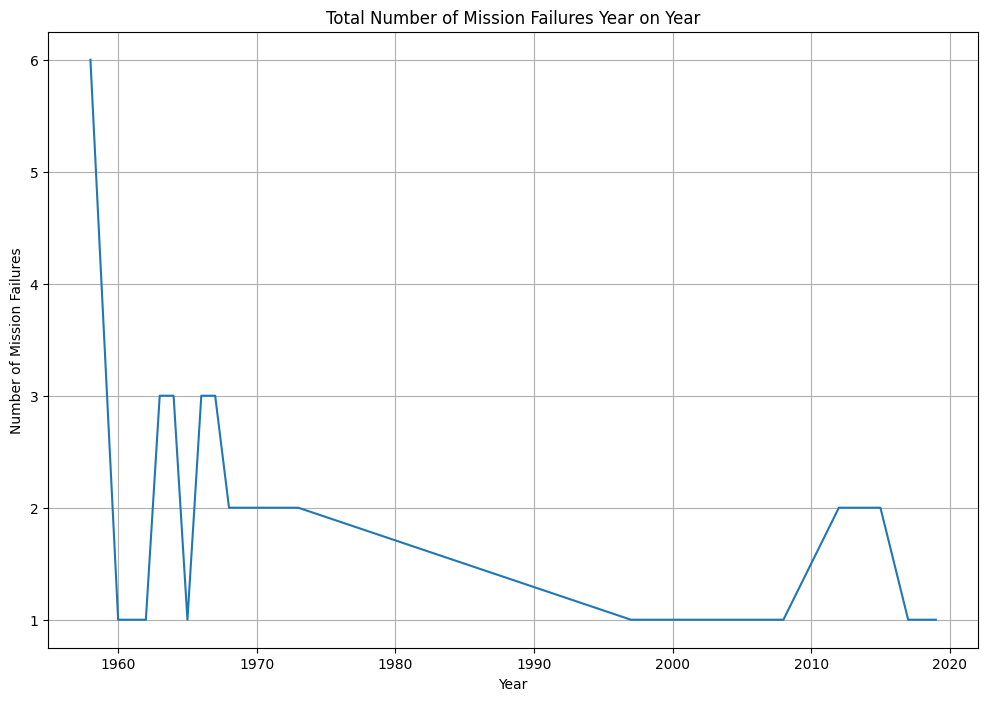

In [154]:
failures_per_year = df_data[df_data['Mission_Status'] == 'Failure'].groupby('Year').size().reset_index(name='number_of_failures')

plt.figure(figsize=(12, 8))
sns.lineplot(x='Year', y='number_of_failures', data=failures_per_year)
plt.xlabel('Year')
plt.ylabel('Number of Mission Failures')
plt.title('Total Number of Mission Failures Year on Year')
plt.grid(True)
plt.show()

## Chart the Percentage of Failures over Time

Did failures go up or down over time? Did the countries get better at minimising risk and improving their chances of success over time?

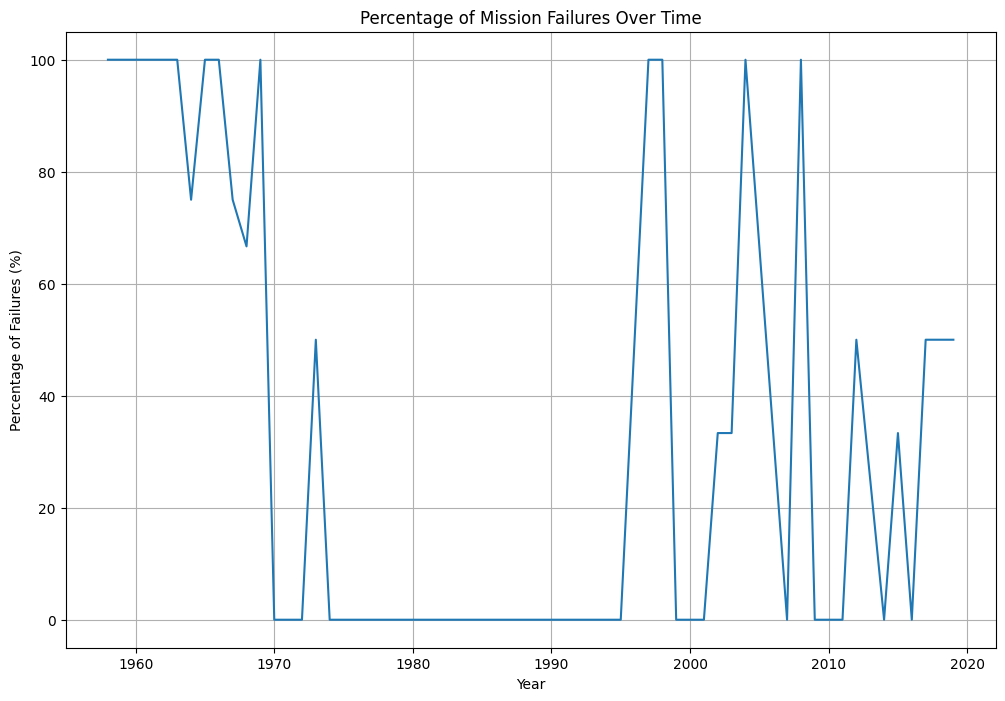

In [155]:

total_launches_per_year = df_data.groupby('Year').size().reset_index(name='total_launches')
failures_per_year = df_data[df_data['Mission_Status'] == 'Failure'].groupby('Year').size().reset_index(name='number_of_failures')

failure_percentage_per_year = pd.merge(total_launches_per_year, failures_per_year, on='Year', how='left').fillna(0)
failure_percentage_per_year['failure_percentage'] = (failure_percentage_per_year['number_of_failures'] / failure_percentage_per_year['total_launches']) * 100

plt.figure(figsize=(12, 8))
sns.lineplot(x='Year', y='failure_percentage', data=failure_percentage_per_year)
plt.xlabel('Year')
plt.ylabel('Percentage of Failures (%)')
plt.title('Percentage of Mission Failures Over Time')
plt.grid(True)
plt.show()



In [156]:

correlation = failure_percentage_per_year['Year'].corr(failure_percentage_per_year['failure_percentage'])

print(f"\nCorrelation between Year and Failure Percentage: {correlation:.2f}")

if correlation < 0:
    print("The percentage of failures generally went down over time.")
    print("This suggests countries got better at minimising risk and improving their chances of success.")
elif correlation > 0:
    print("The percentage of failures generally went up over time.")
    print("This suggests countries did not necessarily get better at minimising risk and improving their chances of success.")
else:
    print("There is no clear linear trend in the percentage of failures over time.")


Correlation between Year and Failure Percentage: -0.27
The percentage of failures generally went down over time.
This suggests countries got better at minimising risk and improving their chances of success.


# For Every Year Show which Country was in the Lead in terms of Total Number of Launches up to and including including 2020)

Do the results change if we only look at the number of successful launches?

In [157]:

df_until_2020 = df_data[df_data['Year'] <= 2020].copy()

launches_by_year_country_cumulative = df_until_2020.groupby(['Year', 'country']).size().reset_index(name='launches_this_year')

launches_by_year_country_cumulative = launches_by_year_country_cumulative.sort_values(by=['country', 'Year'])

launches_by_year_country_cumulative['cumulative_launches'] = launches_by_year_country_cumulative.groupby('country')['launches_this_year'].cumsum()

In [158]:

leading_country_by_year = launches_by_year_country_cumulative.loc[launches_by_year_country_cumulative.groupby('Year')['cumulative_launches'].idxmax()]

print("Leading Country by Total Cumulative Launches (Up to and Including 2020):")
print(leading_country_by_year[['Year', 'country', 'cumulative_launches']].to_string(index=False))

Leading Country by Total Cumulative Launches (Up to and Including 2020):
    Year country  cumulative_launches
1,958.00     USA                    6
1,960.00     KAZ                    1
1,962.00     USA                    7
1,963.00     USA                    9
1,964.00     USA                   10
1,965.00     RUS                    3
1,966.00     RUS                    4
1,967.00     USA                   11
1,968.00     RUS                    6
1,969.00     JPN                    4
1,970.00     RUS                    7
1,971.00     RUS                   10
1,972.00     KAZ                    8
1,973.00     RUS                   12
1,974.00     KAZ                   10
1,975.00     KAZ                   11
1,976.00     USA                   14
1,977.00     RUS                   17
1,978.00     RUS                   19
1,979.00     RUS                   22
1,980.00     RUS                   23
1,981.00     RUS                   28
1,982.00     USA                   17
1,983.00     RU

In [159]:

successful_launches_until_2020 = df_until_2020[df_until_2020['Mission_Status'] == 'Success'].copy()

successful_launches_by_year_country_cumulative = successful_launches_until_2020.groupby(['Year', 'country']).size().reset_index(name='successful_launches_this_year')

successful_launches_by_year_country_cumulative = successful_launches_by_year_country_cumulative.sort_values(by=['country', 'Year'])

successful_launches_by_year_country_cumulative['cumulative_successful_launches'] = successful_launches_by_year_country_cumulative.groupby('country')['successful_launches_this_year'].cumsum()


In [160]:

leading_country_by_year_success = successful_launches_by_year_country_cumulative.loc[successful_launches_by_year_country_cumulative.groupby('Year')['cumulative_successful_launches'].idxmax()]

print("\nLeading Country by Total Cumulative Successful Launches (Up to and Including 2020):")
print(leading_country_by_year_success[['Year', 'country', 'cumulative_successful_launches']].to_string(index=False))


Leading Country by Total Cumulative Successful Launches (Up to and Including 2020):
    Year country  cumulative_successful_launches
1,964.00     KAZ                               1
1,967.00     AUS                               1
1,968.00     KAZ                               2
1,970.00     RUS                               1
1,971.00     RUS                               4
1,972.00     KAZ                               5
1,973.00     KAZ                               6
1,974.00     KAZ                               7
1,975.00     KAZ                               8
1,976.00     KAZ                               9
1,977.00     KAZ                              10
1,978.00     RUS                              12
1,979.00     RUS                              15
1,980.00     RUS                              16
1,981.00     RUS                              21
1,982.00     USA                               5
1,983.00     RUS                              22
1,984.00     RUS                 

In [161]:

merged_leaders = pd.merge(
    leading_country_by_year[['Year', 'country']],
    leading_country_by_year_success[['Year', 'country']],
    on='Year',
    suffixes=('_Total', '_Successful')
)

print("\nComparison of Leading Countries (Total vs. Successful Launches up to 2020):")
print(merged_leaders.to_string(index=False))



Comparison of Leading Countries (Total vs. Successful Launches up to 2020):
    Year country_Total country_Successful
1,964.00           USA                KAZ
1,967.00           USA                AUS
1,968.00           RUS                KAZ
1,970.00           RUS                RUS
1,971.00           RUS                RUS
1,972.00           KAZ                KAZ
1,973.00           RUS                KAZ
1,974.00           KAZ                KAZ
1,975.00           KAZ                KAZ
1,976.00           USA                KAZ
1,977.00           RUS                KAZ
1,978.00           RUS                RUS
1,979.00           RUS                RUS
1,980.00           RUS                RUS
1,981.00           RUS                RUS
1,982.00           USA                USA
1,983.00           RUS                RUS
1,984.00           RUS                RUS
1,985.00           RUS                RUS
1,986.00           RUS                RUS
1,987.00           RUS                RUS

In [162]:

results_change = not merged_leaders['country_Total'].equals(merged_leaders['country_Successful'])

if results_change:
    print("\nThe results for the leading country *do* change when looking only at successful launches compared to total launches.")
else:
     print("\nThe results for the leading country *do not* change when looking only at successful launches compared to total launches.")


The results for the leading country *do* change when looking only at successful launches compared to total launches.


# Create a Year-on-Year Chart Showing the Organisation Doing the Most Number of Launches

Which organisation was dominant in the 1970s and 1980s? Which organisation was dominant in 2018, 2019 and 2020?

In [164]:

launches_by_year_organisation = df_data.groupby(['Year', 'Organisation']).size().reset_index(name='number_of_launches')

launches_by_year_organisation['Organisation'] = launches_by_year_organisation['Organisation'].astype(str)


most_launches_each_year = launches_by_year_organisation.loc[launches_by_year_organisation.groupby('Year')['number_of_launches'].idxmax()]





In [165]:
print("\nOrganisations with the most launches per year:")
print(most_launches_each_year[['Year', 'Organisation', 'number_of_launches']].to_string(index=False))

dominant_70s_80s = most_launches_each_year[(most_launches_each_year['Year'] >= 1970) & (most_launches_each_year['Year'] <= 1989)]
dominant_70s_80s_counts = dominant_70s_80s['Organisation'].value_counts()
print("\nDominant organisation(s) in the 1970s and 1980s (most years with highest launches):")
print(dominant_70s_80s_counts.head())

dominant_2018_2020 = most_launches_each_year[most_launches_each_year['Year'].isin([2018, 2019, 2020])]
print("\nDominant organisation in 2018, 2019, and 2020:")
print(dominant_2018_2020[['Year', 'Organisation', 'number_of_launches']].to_string(index=False))


Organisations with the most launches per year:
    Year     Organisation  number_of_launches
1,958.00          US Navy                   6
1,960.00        RVSN USSR                   1
1,962.00     US Air Force                   1
1,963.00 General Dynamics                   1
1,964.00        RVSN USSR                   3
1,965.00        RVSN USSR                   1
1,966.00               UT                   2
1,967.00             AMBA                   1
1,968.00        RVSN USSR                   2
1,969.00             CASC                   1
1,970.00        RVSN USSR                   1
1,971.00        RVSN USSR                   3
1,972.00        RVSN USSR                   3
1,973.00        RVSN USSR                   3
1,974.00        RVSN USSR                   1
1,975.00        RVSN USSR                   1
1,976.00  Martin Marietta                   2
1,977.00        RVSN USSR                   5
1,978.00        RVSN USSR                   3
1,979.00        RVSN USSR       

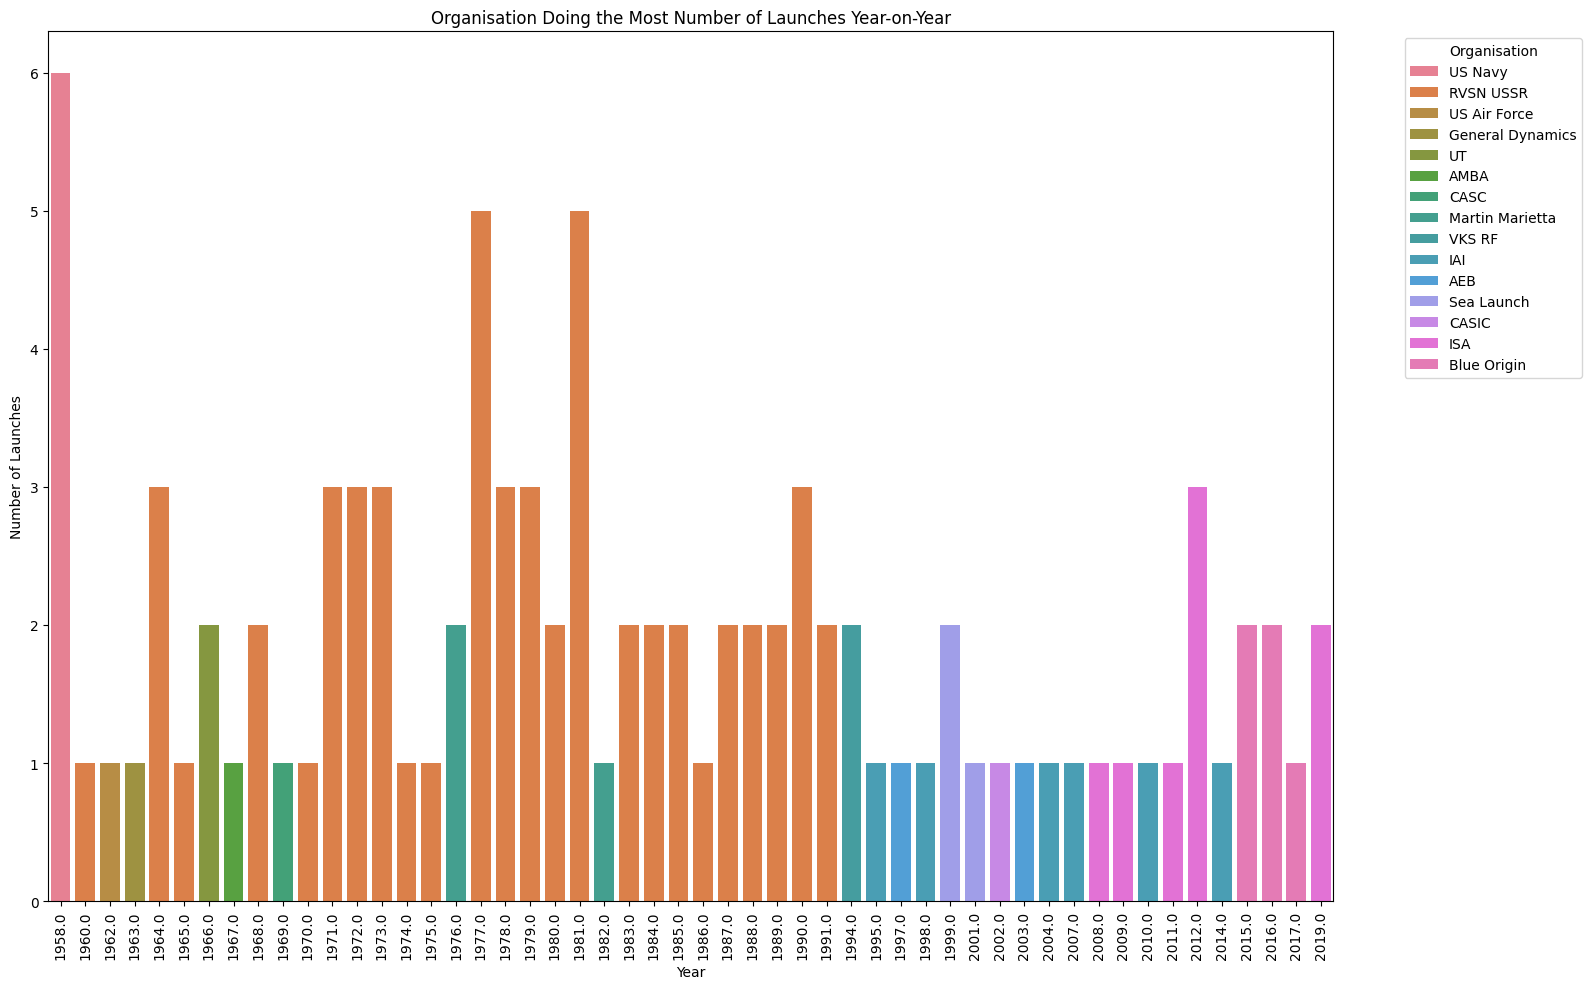

In [166]:
plt.figure(figsize=(16, 10))
sns.barplot(x='Year', y='number_of_launches', hue='Organisation', data=most_launches_each_year, dodge=False)
plt.xlabel('Year')
plt.ylabel('Number of Launches')
plt.title('Organisation Doing the Most Number of Launches Year-on-Year')
plt.xticks(rotation=90)
plt.legend(title='Organisation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()